# A/B Testing: Step-by-step guide with Python

A/B testing is a user experience research methodology. A/B tests consist of a randomized experiment that usually involves two variants, although the concept can be also extended to multiple variants of the same variable.

## Methodology

### Design Experiment

1. Formulating a hypothesis
2. Choosing the variables (how to split control/treatment group?
3. Choose a sample size, N

### Collect data
1. Conduct Experiment
2. Check and clean data (remove outliers)
3. Randomly sample N rows from dataframe for each group

### Visualize the result
1. Basic statistics


### Testing the hypothesis
1. Select an appropriate test
2. Conduct the test to get p-value

### Draw conclusions

-------------------------------------------------------------------------

## Dataset

This dataset is taken from kaggle https://www.kaggle.com/code/ekrembayar/a-b-testing-step-by-step-hypothesis-testing/notebook.

Dataset:
- userid: A unique number that identifies each player.
- version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds: The number of game rounds played by the player during the first 14 days after install.
- retention_1: Did the player come back and play 1 day after installing?
- retention_7: Did the player come back and play 7 days after installing?

## Import Libraries

In [3]:
# Base
# -----------------------------------
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

## Import File

In [57]:
path = "cookie_cats.csv"

def load(path, info = True):
    
    import pandas as pd
    import io
    
    if len(path.split(".csv")) > 1:
        read = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        read = pd.read_excel(path)
    
    if info:
        if len(read) > 0:
            print("# Data imported!")
            print("# ------------------------------------", "\n")
        
            print("# DIMENSIONS -------------------------")
            print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
    
            print("# DTYPES -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Object Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
    
            if len(read.select_dtypes("integer").columns) > 0:
                print("Integer Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(read.select_dtypes("float").columns) > 0:
                print("Float Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")
    
            if len(read.select_dtypes("bool").columns) > 0:
                print("Bool Variables:", "\n", "# of Variables:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
    
            print("# MISSING VALUE ---------------------")
            print("Are there any missing values? \n ", np.where(read.isnull().values.any() == False, 
                                                            "No missing value!", "Data includes missing value!"), "\n")
            
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# MEMORY USAGE ---------------------- \n", info)
          
        else:
            print("# Data did not import!")
    
    return read
    
ab = load(path, info = True)
ab.head()

# Data imported!
# ------------------------------------ 

# DIMENSIONS -------------------------
Observation: 90189 Column: 5 

# DTYPES -----------------------------
Object Variables: 
 # of Variables: 1 
 ['version'] 

Integer Variables: 
 # of Variables: 2 
 ['userid', 'sum_gamerounds'] 

Bool Variables: 
 # of Variables: 2 
 ['retention_1', 'retention_7'] 

# MISSING VALUE ---------------------
Are there any missing values? 
  No missing value! 

# MEMORY USAGE ---------------------- 
 2.2+ MB


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Exploratory data analysis

In [58]:
# Number of Unique User
print("Unique User? ",ab.userid.nunique() == ab.shape[0])

# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

Unique User?  True


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [59]:
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


## Remove Outliers

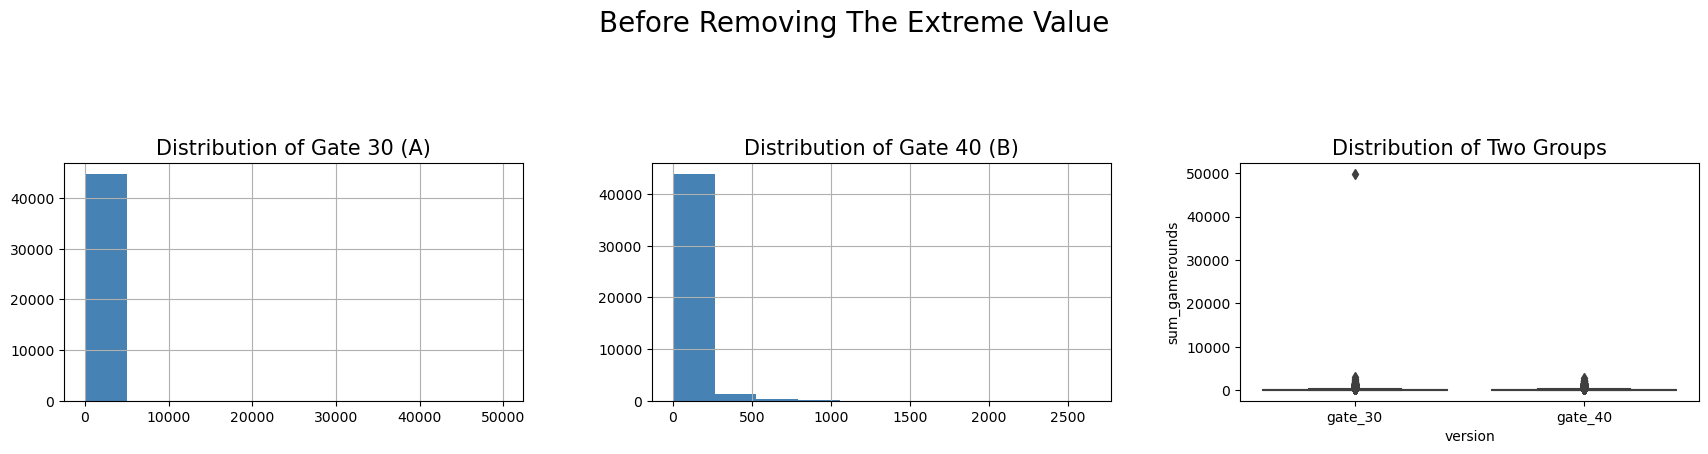

In [60]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

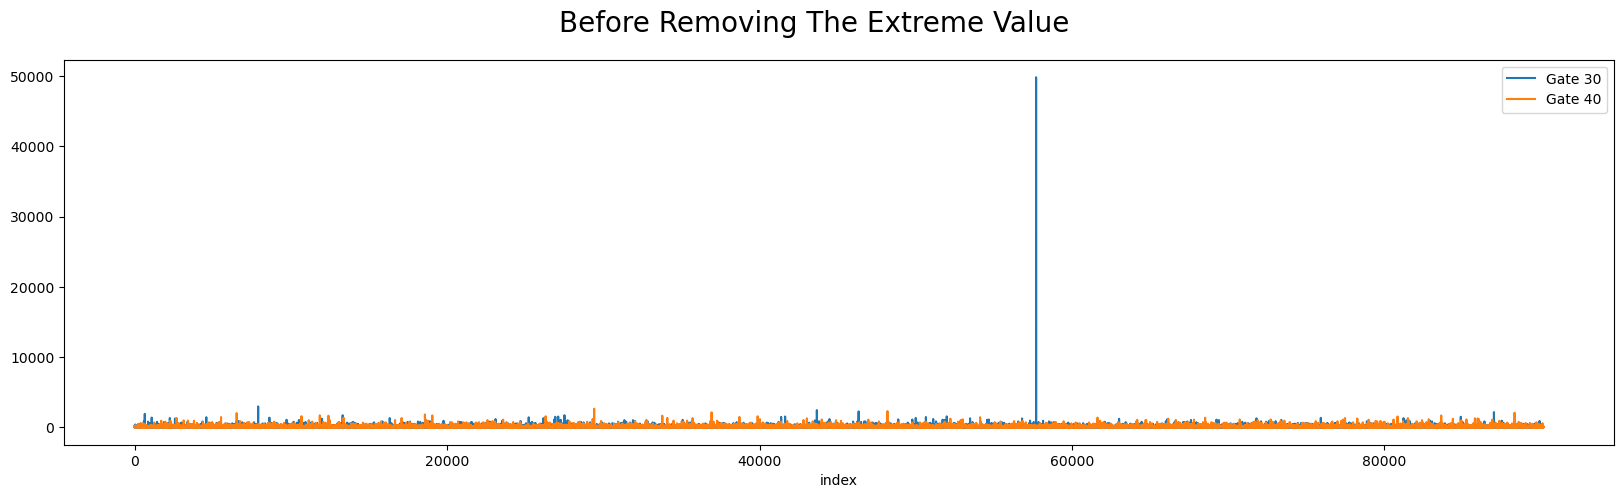

In [61]:
ab[ab.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20);

In [62]:
ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


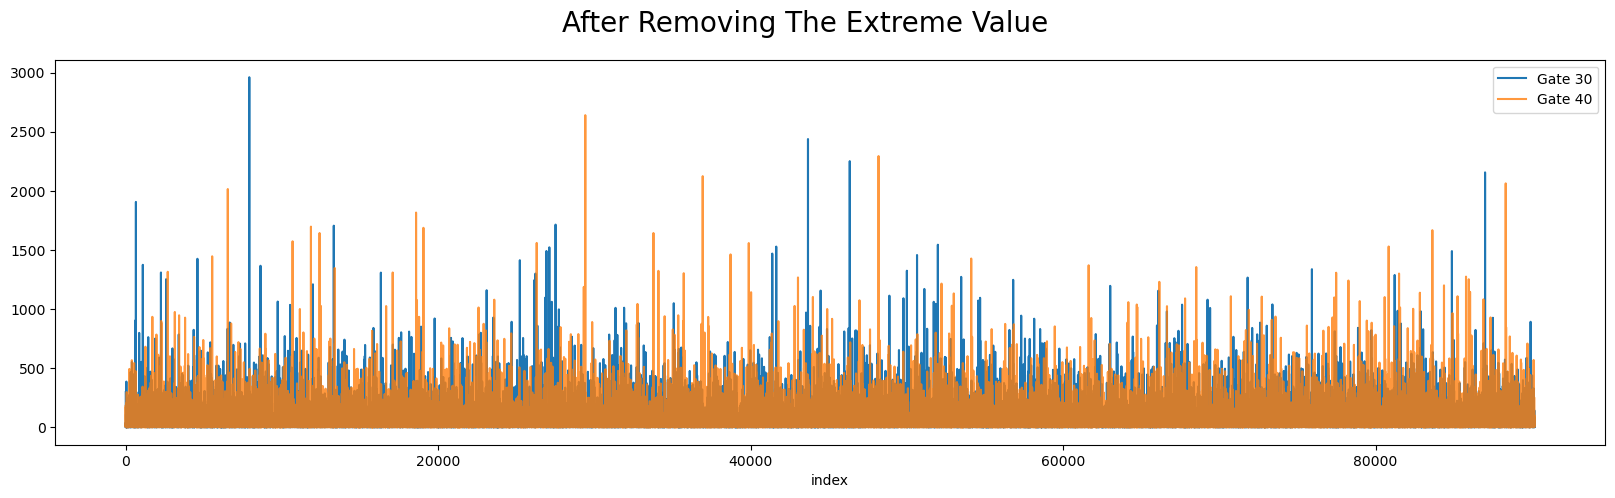

In [63]:
ab[(ab.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

In [64]:
ab

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [15]:
ab.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665  6.0000 16.3591  36.5284  1072
        True         20034 48.0000 94.4117 135.0377  2961
gate_40 False        25370  6.0000 16.3404  35.9258  1241
        True         20119 49.0000 95.3812 137.8873  2640

In [33]:
ab.groupby(["version"]).retention_7.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,0.0000,0.1902,0.3925,True
gate_40,45489,0.0000,0.1820,0.3858,True


### Retention rate

In [35]:
print("Retention_rate for gate_30 version: ",0.1902)
print("Retention_rate for gate_40 version: ",0.1820)

Retention_rate for gate_30 version:  0.1902
Retention_rate for gate_40 version:  0.182


## Design Experiment

We would like investigate whether if version in gate_40 is better than gate_30. The metrics that is being used here is the retention rate 7 day.

Hypothesis: Retention rate (7 days) for version gate_40 is better than gate_30. Now let's say we are satisfied with retention rate of a increase of 2%.

The current retention rate (gate_30 version) is 45.18%, if the retention is increased to 47.18% or higher, we would consider it as good improvement.

The parameters that is being used here:
- power (probability to avoid type II error): 80%
- alpha (probability of hitting type I error): 5%

### Choose Sample Size

In [31]:
import statsmodels.stats.api as sms
from math import ceil
effect_size = sms.proportion_effectsize(0.19, 0.21)    # Calculating effect size based on our expected rates
print(effect_size)
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print("Number of sample required :",required_n)

-0.05001401253012072
Number of sample required : 6276


## AB testing



1. Define Null Hypothesis

    Null Hypothesis: Retention rate for gate_40 is lower than gate_30 (p1 > p2). It does not perform better in the new version.


2. Choose sample based on calculated sample size.

3. Perform z-test to get p-value and confidence interval.

### Random Sampling

In [32]:
control_sample = ab[ab['version'] == 'gate_30'].sample(n=required_n, random_state=22)
treatment_sample = ab[ab['version'] == 'gate_40'].sample(n=required_n, random_state=22)

### Perform z-test

Alternative attributes:
- if alternative = smaller, p1 < p2 (control < treatment)
- if alternative = larger, p1 > p2 (control > treatment)

Here since our null hypothesis is p1 < p2, we would choose alternative = smaller.

In [45]:
def z_test(ab,version_col,v1,v2,target_var,alternative = 'two-sided'):
    from statsmodels.stats.proportion import proportions_ztest, proportion_confint


    control_results = ab[ab[version_col] == v1][target_var]
    treatment_results = ab[ab[version_col] == v2][target_var]

    n_con = control_results.count()
    n_treat = treatment_results.count()

    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [n_con, n_treat]

    z_stat, pval = proportions_ztest(successes, nobs=nobs, alternative = alternative)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

    print(f'z statistic: {z_stat:.2f}')
    print(f'p-value: {pval:.3f}')
    print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
    print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

In [48]:
z_test(ab,"version","gate_30","gate_40","retention_7",alternative = "smaller")

z statistic: 3.16
p-value: 0.999
ci 95% for control group: [0.187, 0.194]
ci 95% for treatment group: [0.178, 0.186]


## Draw conclusion

Since p-value = 0.999, which is way above our alpha = 0.05 threshold, we CANNOT reject the null hypothesis H0, which means that the new version does not perform better than the old version.

Additionally, if we look at confidence interval for `gate_40` group [0.178,0.186], it is way below compared to `gate_30` group [0.187,0.194].

## Appendix (A/B Testing on numerical variables)

In above code, we show how we can run AB testing on a categorical variable, which we can simply conduct a z-test when we have a large enough sample size.

What if we have a numerical variable? For example, sum of game played in our previous example.

In [67]:
# Define A/B groups
ab["version"] = np.where(ab.version == "gate_30", "A", "B")
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


### Quick solution for AB Testing on numerical variables

Steps:
1. Shapiro Test to determine whether they are under normal distribution

    i. If not normal distribution, we conduct Whitney U test (non-parametic test) to test if they share same distribution.
    
    ii. If normal distribution, we conduct Levene test to check if they have same variance.
    
    iii. If same variance, conduct normal t-test.
    
    iv. If diff variance, conduct Welch's t-test.

In [71]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target, alternative = 'two-sided'):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True, alternative = alternative)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False, alternative = alternative)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB, alternative = alternative)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    
    if alternative == 'two-sided':
        temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    elif alternative == 'less':
        temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A is better!", "B is better")
    elif alternative == 'greater':
        temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "B is better!", "A is better")
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp 

In [74]:
AB_Test(ab,'version','sum_gamerounds',alternative = 'greater')

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.0254,A is better


### Interpretation

1. Shapiro-Wilk test
    - Null Hypothesis: the population is normally distributed.
    - Interpretation: p < alpha, H0 is rejected and data is NOT normally distributed.
    https://en.wikipedia.org/wiki/Shapiro–Wilk_test

2. Mann-Whitney U test
    - Null Hypothesis: the distribution underlying sample x is the same as the distribution underlying sample y.
    - Interpretation: p < alpha, H0 is rejected and both X and Y data has no similar distribution.
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
    
3. Levene test
    - Null hypothesis: All input samples are from populations with equal variances.
    - Interpretation: p < alpha, H0 is rejected and both X and Y has NO equal variances.
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html

4. T test
    - Null hypothesis: 2 independent samples have identical average (expected) values.
    - Interpretation: p < alpha, H0 is rejected and both X and Y has NO equal mean.
    - Assumption: 
        - I.I.D
        - X and Y has equal variances.
        - X and Y follows normal distribution.
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
    
